In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import numpy as np
import os, random,sys

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = 'E:\lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

MPS device not found.


torch.Size([250, 250, 3])


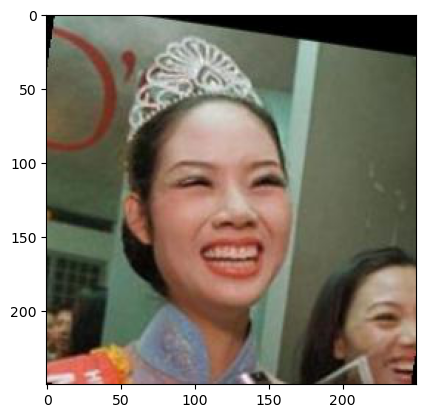

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [7]:
for x, y in dataloader:
    print("Shape of the image tensor:", x.shape)
    print("Explanation of each dimension:")
    print("First dimension (batch size):", x.shape[0])
    print("Second dimension (channels):", x.shape[1])
    print("Third dimension (height):", x.shape[2])
    print("Fourth dimension (width):", x.shape[3])
    break

Shape of the image tensor: torch.Size([32, 3, 250, 250])
Explanation of each dimension:
First dimension (batch size): 32
Second dimension (channels): 3
Third dimension (height): 250
Fourth dimension (width): 250


In the above we got 4 dimensions where the first dimension represents the batch size, second one represents the number of channels that is red,blue and green, third one represents the the height of the image and the fourth one represents the width of the image

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [8]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=4, stride=2, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        # Decoder layers
        self.convtrans1 = nn.ConvTranspose2d(in_channels=24, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.convtrans2 = nn.ConvTranspose2d(in_channels=16, out_channels=12, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.sigmoid_1 = nn.Sigmoid()
        self.convtrans3 = nn.ConvTranspose2d(in_channels=12, out_channels=3, kernel_size=4, stride=2, padding=1, output_padding=1)
        self.sigmoid = nn.Sigmoid()
        self.upsample = nn.Upsample(size=(250, 250), mode='nearest')

    def encoder(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        return x

    def decoder(self, x):
        x = self.convtrans1(x)
        x = self.relu1(x)
        x = self.convtrans2(x)
        x = self.sigmoid_1(x)
        x = self.convtrans3(x)
        x = self.sigmoid(x)
        x=self.upsample(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [9]:
autoencoder = AE()
for images,y in dataloader:
    break 
sample_image = images[0].unsqueeze(0)

with torch.no_grad():
    encoded_output = autoencoder.encoder(sample_image)
    print("Encoded Output Shape:", encoded_output.shape)

    reconstructed_image = autoencoder.decoder(encoded_output)
    print("Decoded Output Shape:", reconstructed_image.shape)


Encoded Output Shape: torch.Size([1, 24, 31, 31])
Decoded Output Shape: torch.Size([1, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [11]:
import torch.optim as optim

autoencoder = AE()

total_params = sum(p.numel() for p in autoencoder.parameters())
print(f"Total no.of parameters: {total_params}")

loss_function = nn.MSELoss()
learning_rate = 0.001 
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

print(f"\nOptimizer: Adam with learning rate {learning_rate}")
print(f"Loss Function: Mean Squared Error (MSE)")

Total no.of parameters: 11683

Optimizer: Adam with learning rate 0.001
Loss Function: Mean Squared Error (MSE)


In the above code we used the Mean Squared Error as loss function which is a common loss function used in regression tasks, including neural network training. It calculates the average of squared differences between predicted and actual values. I choose MSE loss function because it is appropriate because it encourages the model to produce reconstructions that closely match the input data pixel-wise.

The we used Adam Optimizer that updates the weights of the neural network during training. It requires two arguments those are learning rate and parameters. I choose this optmizer because of its ability to handle different types of data distributions effectively improved training performance, making it a suitable choice for training autoencoders.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [13]:
loss_function = nn.MSELoss()
learning_rate = 0.001
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

num_epochs = 10

for epoch in range(num_epochs):
    start_loss = 0
    for batch_idx, (inputs, _) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = loss_function(outputs, inputs)
        loss.backward()
        optimizer.step()
        start_loss = start_loss + loss.item()
    epoch_loss = start_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}")
    
    # if loss is not decreasing we need to troubleshoot
    if epoch > 0 and epoch_loss >= prev_epoch_loss:
        print(" Loss is not decreasing. Adjust learning rate or model architecture.")
    
    prev_epoch_loss = epoch_loss

Epoch [1/10] - Loss: 0.0116
Epoch [2/10] - Loss: 0.0076
Epoch [3/10] - Loss: 0.0062
Epoch [4/10] - Loss: 0.0055
Epoch [5/10] - Loss: 0.0052
Epoch [6/10] - Loss: 0.0049
Epoch [7/10] - Loss: 0.0047
Epoch [8/10] - Loss: 0.0045
Epoch [9/10] - Loss: 0.0044
Epoch [10/10] - Loss: 0.0043


If we see that the loss value is not decreasing for the epochs, then we need to change the number of epochs we choose, we have to adjust the learning rates and as mentioned in the code we can also modify the architecture of the model inorder to get the decreasing learning rates at the end of each epoch.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

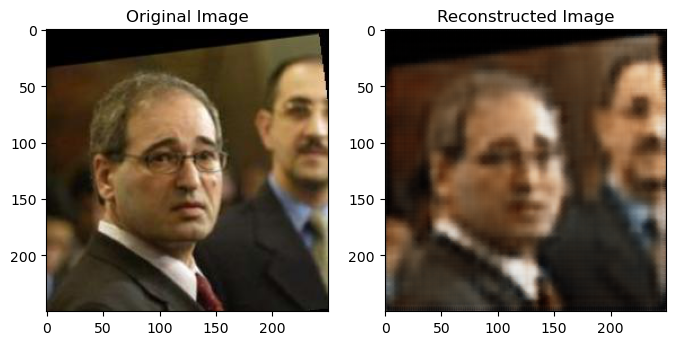

In [14]:
autoencoder.eval()
random_index = random.randint(0, len(dataloader.dataset) - 1)
original_image, _ = dataloader.dataset[random_index]

with torch.no_grad():
    encoded_output = autoencoder.encoder(original_image.unsqueeze(0))
    reconstructed_image = autoencoder.decoder(encoded_output).squeeze(0)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image.permute(1, 2, 0)) 

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image.permute(1, 2, 0))

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

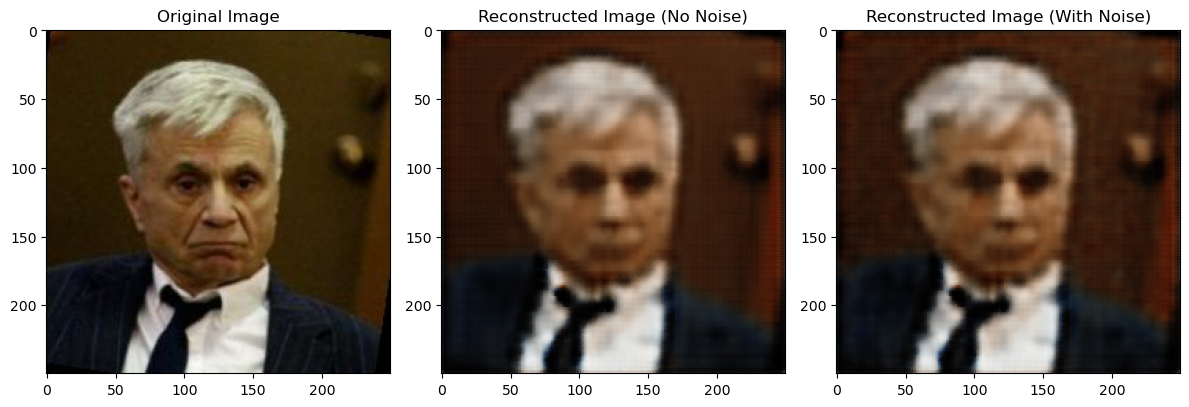

In [15]:

autoencoder.eval()

random_index = random.randint(0, len(dataloader.dataset) - 1)
original_image, _ = dataloader.dataset[random_index]

with torch.no_grad():
    encoded_output = autoencoder.encoder(original_image.unsqueeze(0))

noise = torch.randn_like(encoded_output) * 0.1
noisy_encoded_output = encoded_output + noise

with torch.no_grad():
    reconstructed_image_with_noise = autoencoder.decoder(noisy_encoded_output).squeeze(0)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(original_image.permute(1, 2, 0))

plt.subplot(1, 3, 2)
plt.title('Reconstructed Image (No Noise)')
reconstructed_image = autoencoder.decoder(encoded_output).squeeze(0)
plt.imshow(reconstructed_image.permute(1, 2, 0).detach().cpu().numpy())  

plt.subplot(1, 3, 3)
plt.title('Reconstructed Image (With Noise)')
plt.imshow(reconstructed_image_with_noise.permute(1, 2, 0).detach().cpu().numpy())

plt.tight_layout()
plt.show()


Here, Adding noise to the encoded representation alters the information content of the representation there by introducing randomness. This modification affects the decoders ability to reconstruct the original image accurately. The addition of noise typically results in a reconstructed image (with noise) that exhibits imperfections.